In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score
import pandas as pd
import seaborn as sns
from statsmodels import api as sm
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
import os
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
from statsmodels import api as sm
from sklearn import metrics

In [2]:
data_dir='filtered_csv_label'
original = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df=df[df['day']<=9]
df

,original,label,time,day
0,53.4,0,15,0
1,52.8,0,15,0
2,52.8,0,15,0
3,53.2,0,15,0
4,53.6,0,15,0
...,...,...,...,...
3995345,45.9,0,5,9
3995346,45.6,0,5,9
3995347,45.8,0,5,9
3995348,45.7,0,5,9


In [3]:
def make_data(x, str,w):
    x=pd.DataFrame(x)
    window=w
    for i in range(1, window):
        column=f'{str}_lag{i}'
        x[column]=x[str].shift(i)
    return x

def make_label(x, w):
    window=w
    x['label_all']=x['label']
    for i in range(1, window):
        x.loc[(x['label_all']==1)|(x['label'].shift(i)==1), 'label_all']=1
        x.loc[(x['label_all']==0)&(x['label'].shift(i)==0), 'label_all']=0
    
    x['label']=x['label_all']
    return x[['label']]

def calc_leq(df, unit):
    df.reset_index(inplace=True, drop=True)
    for i in range(int(len(df)/unit)+1):
        hour_df=df.loc[i*unit:(i+1)*unit, 'original'].copy()
        N=len(hour_df)
        Leq=10*np.log10(np.sum(np.power(10, hour_df/10)))-10*np.log10(N)
        df.loc[i*unit:(i+1)*unit, 'leq']=Leq
    return df

def leq_filter(df):
    df=calc_leq(df, 18000)
    df.loc[(df['original']<df['leq']), 'd']=0
    return df

def validate(test_v, anorm, thr):
    test_v['z']=np.where(anorm>=thr, 1, 0)
    test_v.reset_index(inplace=True, drop=True)

    #     適合率
    tp=test_v[(test_v['label']==1)&(test_v['z']==1)]
    z_p=test_v[test_v['z']==1]
    pre_score=len(tp)/len(z_p)

    #     再現率
    df_anorm=[]
    search= 1 if test_v.loc[0, 'label']==0 else 0
    for num in range(len(test_v)):
        if search==1 and test_v.loc[num, 'label']==search:
            start=num
            search=0
        elif search==0 and test_v.loc[num, 'label']==search:
            stop=num-1
            anorm_range=test_v.loc[start:stop].copy()
            df_anorm.append(anorm_range)
            search=1
            
    count=[]
    for i in range(len(df_anorm)):
        if len(df_anorm[i].loc[df_anorm[i]['z']==1])>=1:
               count.append(i)    

    re_score=len(count)/len(df_anorm)

    return pre_score, re_score

def figure(df_test, anorm, d, thr):
    df_test['z']=np.where(d>=thr, 1, 0)
    
    z=df_test['z'].values*100
    test_plot=df_test['original'].values
    num_ax=math.ceil(len(test_plot)/17999)
    label=df_test['label'].values*100
    label_index=range(len(label))
    time_unit=60
    time=[t*0.2/60 for t in range(len(anorm))]
    plt.rcParams["font.size"] = 30

    fig, ax=plt.subplots(num_ax, 1, figsize=(35, 15*num_ax))
    for i in range(num_ax):
        ax[i].plot(time, anorm, '-r',linewidth = 1 )
        ax[i].plot(time, test_plot, '-k',linewidth = 2)
        ax[i].fill_between(time, label, facecolor='lime' )
        ax[i].fill_between(time, z, facecolor='coral' )
        ax[i].set_ylim(0, 90)
        ax[i].set_xlim(i*time_unit, time_unit*(i+1))
        ax[i].set_xticks(np.arange(60*i, 60*(i+1)))
        ax[i].xaxis.set_tick_params(rotation=70)
    plt.show()

def fig_pr(test_v, d, bins):
    thr_1=np.linspace(d.min(), 0.25, bins-5)
    thr_2=np.linspace(0.26, d.max(), 5)
    thresholds=np.concatenate([thr_1, thr_2])
    precision=np.array([])
    recall=np.array([])
    for i in thresholds:
        p, r=validate(test_v, d, i)
        precision=np.append(precision, p)
        recall=np.append(recall, r)

    auc = metrics.auc(recall, precision)
    f_score=(2*precision*recall)/(precision+recall)
    thr=thresholds[np.argmax(f_score)]

    plt.rcParams["font.size"] = 10
    plt.plot(recall, precision, marker='o', markevery=[np.argmax(f_score)], label='PR curve (AUC = %.2f)'%auc)
    plt.legend()
    plt.title('PR curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.show()

    return precision, recall, f_score, thresholds, thr, auc

def fig_th_f(thresholds, f_score):
    plt.plot(thresholds, f_score, marker="o", markevery=[np.argmax(f_score)])
    plt.xlabel('thresholds')
    plt.ylabel('f_score')
    plt.grid(True)
    plt.show()
    
    return thresholds[np.argmax(f_score)], f_score.max()

In [4]:
df_list=[]
for i in set(df['day']):
    lag=[] 
    window=5
    lag.append(make_data(df.loc[df['day']==i, ['original']], 'original', window))
    lag.append(df.loc[df['day']==i, ['day']])
    df_add_lag=pd.concat(lag, axis=1)
    df_list.append(df_add_lag)
df=pd.concat(df_list)
df=df.dropna().reset_index(drop=True)
df['d']=0
df['z']=0
df

,original,original_lag1,original_lag2,original_lag3,original_lag4,day,d,z
0,53.6,53.2,52.8,52.8,53.4,0,0,0
1,54.0,53.6,53.2,52.8,52.8,0,0,0
2,54.7,54.0,53.6,53.2,52.8,0,0,0
3,55.7,54.7,54.0,53.6,53.2,0,0,0
4,55.5,55.7,54.7,54.0,53.6,0,0,0
...,...,...,...,...,...,...,...,...
3995305,45.9,45.6,45.4,45.9,46.0,9,0,0
3995306,45.6,45.9,45.6,45.4,45.9,9,0,0
3995307,45.8,45.6,45.9,45.6,45.4,9,0,0
3995308,45.7,45.8,45.6,45.9,45.6,9,0,0


## クロスバリデーション（パラメータチューニング）

In [5]:
cv_data_list=df['day'].unique().tolist()
#テストデータ
test_notvalid=[]

In [6]:
for i in range(len(test_notvalid)):
    #検証データ＋訓練データ
    cv_data_list.remove(test_notvalid[i])
cv_data_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

訓練データ：[1, 2, 3, 4, 5, 6, 7, 8, 9]
検証データ：[0]日目
------------異常検知モデルの性能評価（PR曲線AUC）-------------


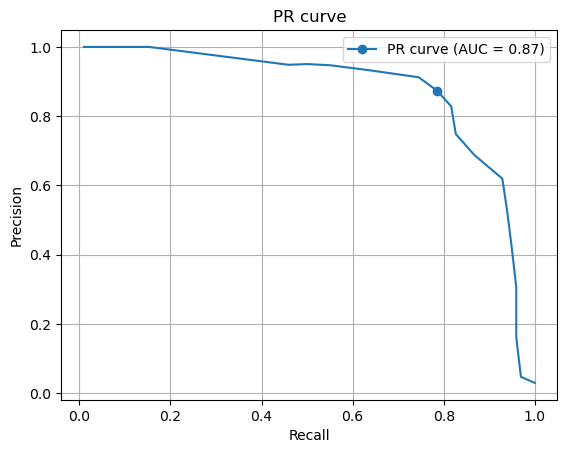

AUC：0.865184033993789
理想の閾値：0.17857142857142855
F値（最高）：0.8272157564905999
適合率（最高）：0.8733459357277883
再現率（最高）：0.7857142857142857
----------------閾値の妥当性評価（F値）------------------
閾値0.18396672088684876
F値：0.8325730697752998
適合率：0.8853754940711462
再現率：0.7857142857142857

訓練データ：[0, 2, 3, 4, 5, 6, 7, 8, 9]
検証データ：[1]日目
------------異常検知モデルの性能評価（PR曲線AUC）-------------


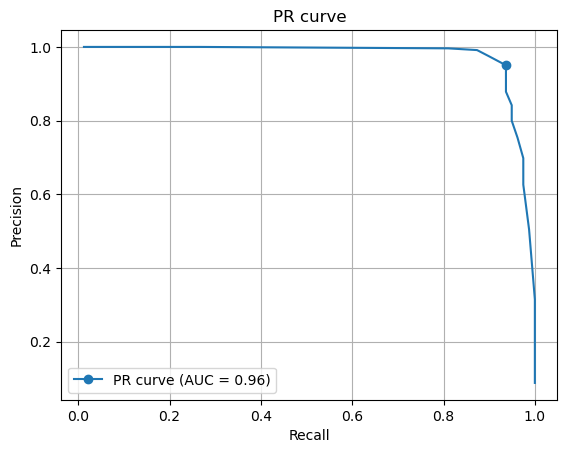

AUC：0.9630017960994375
理想の閾値：0.21428571428571427
F値（最高）：0.9434143083245001
適合率（最高）：0.9502164502164502
再現率（最高）：0.9367088607594937
----------------閾値の妥当性評価（F値）------------------
閾値0.2755937750316672
F値：0.8542049968189557
適合率：0.9976303317535545
再現率：0.7468354430379747

訓練データ：[0, 1, 3, 4, 5, 6, 7, 8, 9]
検証データ：[2]日目
------------異常検知モデルの性能評価（PR曲線AUC）-------------


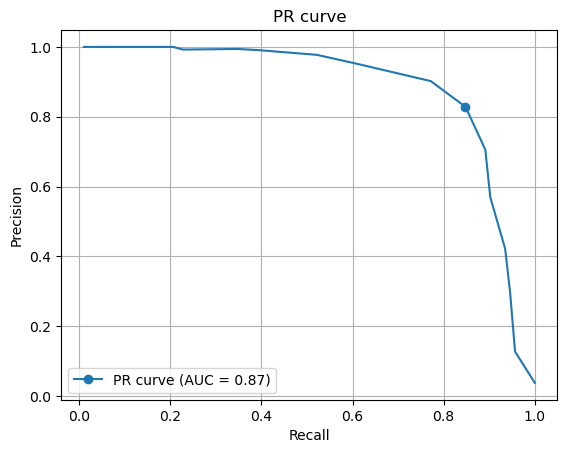

AUC：0.8747868476790316
理想の閾値：0.10714285714285714
F値（最高）：0.8380698878483437
適合率（最高）：0.8285356695869838
再現率（最高）：0.8478260869565217
----------------閾値の妥当性評価（F値）------------------
閾値0.104658389171799
F値：0.8366434840333151
適合率：0.8156956004756243
再現率：0.8586956521739131

訓練データ：[0, 1, 2, 4, 5, 6, 7, 8, 9]
検証データ：[3]日目
------------異常検知モデルの性能評価（PR曲線AUC）-------------


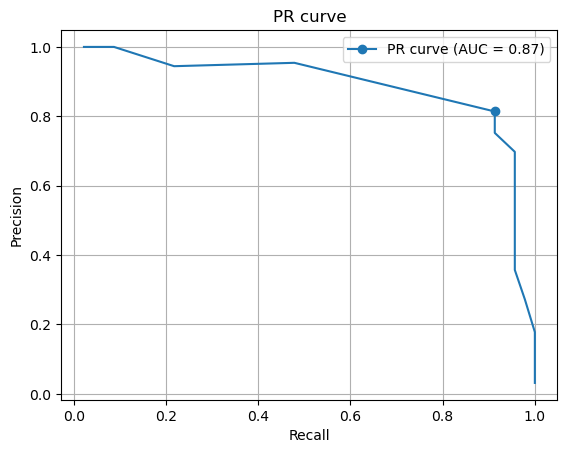

AUC：0.8672886070192622
理想の閾値：0.26
F値（最高）：0.8605994550408719
適合率（最高）：0.8138528138528138
再現率（最高）：0.9130434782608695
----------------閾値の妥当性評価（F値）------------------
閾値0.3685927588944835
F値：0.7308730873087309
適合率：0.9144144144144144
再現率：0.6086956521739131

訓練データ：[0, 1, 2, 3, 5, 6, 7, 8, 9]
検証データ：[4]日目
------------異常検知モデルの性能評価（PR曲線AUC）-------------


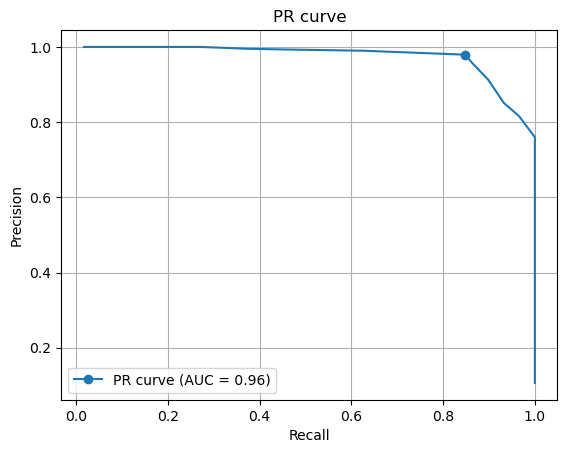

AUC：0.9578473145316314
理想の閾値：0.14285714285714285
F値（最高）：0.908647820637794
適合率（最高）：0.9793621013133208
再現率（最高）：0.847457627118644
----------------閾値の妥当性評価（F値）------------------
閾値0.12917785216846514
F値：0.8998921221886906
適合率：0.9592430858806404
再現率：0.847457627118644

訓練データ：[0, 1, 2, 3, 4, 6, 7, 8, 9]
検証データ：[5]日目
------------異常検知モデルの性能評価（PR曲線AUC）-------------


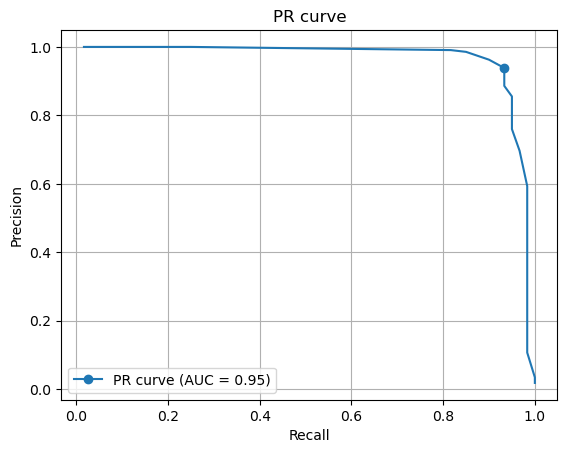

AUC：0.9492802680905594
理想の閾値：0.21428571428571427
F値（最高）：0.9358904109589041
適合率（最高）：0.9384615384615385
再現率（最高）：0.9333333333333333
----------------閾値の妥当性評価（F値）------------------
閾値0.24125745632719642
F値：0.9225986944358097
適合率：0.9655172413793104
再現率：0.8833333333333333

訓練データ：[0, 1, 2, 3, 4, 5, 7, 8, 9]
検証データ：[6]日目
------------異常検知モデルの性能評価（PR曲線AUC）-------------


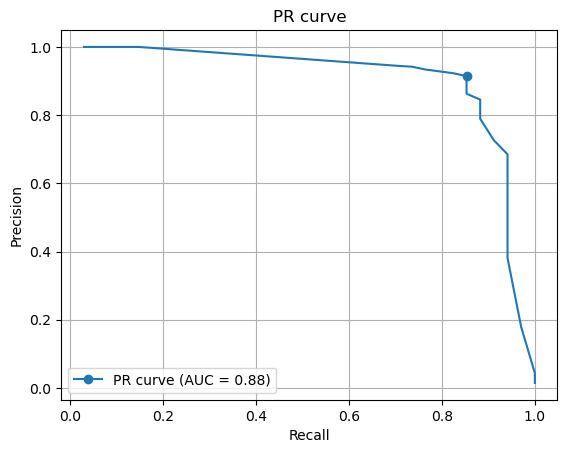

AUC：0.8775768185395412
理想の閾値：0.19642857142857142
F値（最高）：0.882662494666477
適合率（最高）：0.9145299145299145
再現率（最高）：0.8529411764705882
----------------閾値の妥当性評価（F値）------------------
閾値0.17972859388772028
F値：0.8602312719959778
適合率：0.8676470588235294
再現率：0.8529411764705882

訓練データ：[0, 1, 2, 3, 4, 5, 6, 8, 9]
検証データ：[7]日目
------------異常検知モデルの性能評価（PR曲線AUC）-------------


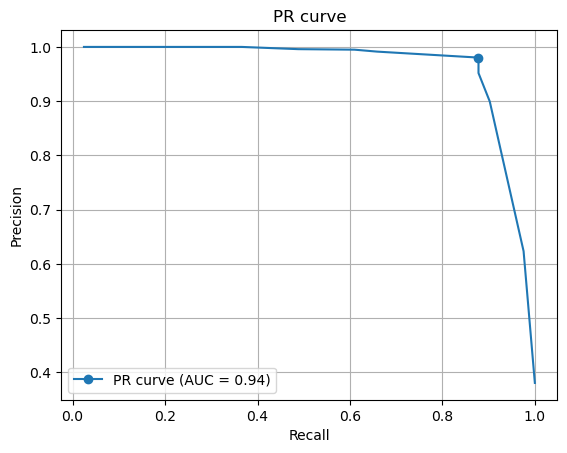

AUC：0.9399254445975366
理想の閾値：0.08928571428571427
F値（最高）：0.9263759828448892
適合率（最高）：0.9803328290468987
再現率（最高）：0.8780487804878049
----------------閾値の妥当性評価（F値）------------------
閾値0.11876421830160566
F値：0.7924184387795535
適合率：0.9946284691136974
再現率：0.6585365853658537

訓練データ：[0, 1, 2, 3, 4, 5, 6, 7, 9]
検証データ：[8]日目
------------異常検知モデルの性能評価（PR曲線AUC）-------------


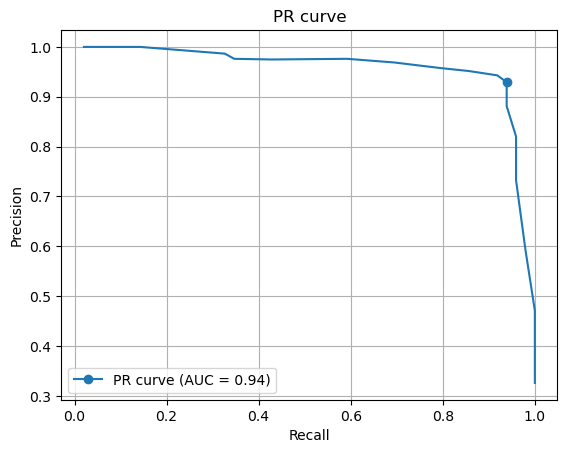

AUC：0.9385983381965832
理想の閾値：0.125
F値（最高）：0.9340077146719699
適合率（最高）：0.9292881032011466
再現率（最高）：0.9387755102040817
----------------閾値の妥当性評価（F値）------------------
閾値0.18697286942743246
F値：0.8197484862598976
適合率：0.9617486338797814
再現率：0.7142857142857143

訓練データ：[0, 1, 2, 3, 4, 5, 6, 7, 8]
検証データ：[9]日目
------------異常検知モデルの性能評価（PR曲線AUC）-------------


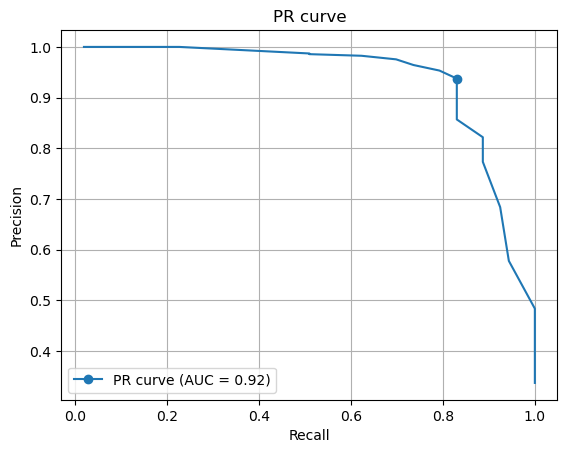

AUC：0.9174979751928116
理想の閾値：0.1607142857142857
F値（最高）：0.8805870580386924
適合率（最高）：0.9375
再現率（最高）：0.8301886792452831
----------------閾値の妥当性評価（F値）------------------
閾値0.1891221110856209
F値：0.8576787865989244
適合率：0.9622857142857143
再現率：0.7735849056603774

----------------総合評価------------------
・異常検知モデルの性能
	AUC平均：0.9150987443940183
・閾値の妥当性
	f値平均：0.8406862438195155


In [7]:
auc_sum=0
f_score_sum=0
#検証データを何日にするか
valid_daynum=1
cv_comb=np.array(cv_data_list).reshape((-1, valid_daynum)).tolist()
for i in cv_comb:
    print(f'訓練データ：{[k for k in cv_data_list if k not in i]}')
    print(f'検証データ：{i}日目')

    test_day=i
    train=df[(~df['day'].isin(test_day))][df.columns[:-3]].reset_index(drop=True)
    test=df[(df['day'].isin(test_day))][df.columns[:-3]].reset_index(drop=True)

    nk = 21
    neigh = NearestNeighbors(n_neighbors=nk)
    neigh.fit(train)
    d = neigh.kneighbors(test)[0]
    d = np.mean(d, axis=1)
    mx = np.max(d)
    d = d / mx
    df.loc[(df['day'].isin(test_day)), 'd']=d
    
    test_v=original[original['day'].isin(test_day)][['original', 'label', 'day']].reset_index(drop=True)
    test_v['d']=d[0]
    for day in test_day:
        tmp=test_v.loc[test_v['day']==day,  'd']
        tmp[window-1:]=df.loc[(df['day']==day), 'd'].values
        test_v.loc[test_v['day']==day,  'd']=tmp
    #道路交通騒音に埋もれている異常音は正常とする
    test_v=leq_filter(test_v)
    d_test=test_v['d'].values
    
    print('------------異常検知モデルの性能評価（PR曲線AUC）-------------')
    thr_bins=20
    p_score, r_score, f_score, thresholds, thr, auc = fig_pr(test_v, d_test, thr_bins)
    print('\033[31m'+f'AUC：{auc}'+'\033[0m')
    print(f'理想の閾値：{thr}')
    print(f'F値（最高）：{f_score.max()}')
    print(f'適合率（最高）：{p_score[np.argmax(f_score)]}')
    print(f'再現率（最高）：{r_score[np.argmax(f_score)]}')
    auc_sum+=auc
    print('----------------閾値の妥当性評価（F値）------------------')
 
    #kmeans
    n_clusters=2
    model = KMeans(n_clusters=n_clusters)  
    model.fit(d.reshape((-1, 1)))
    clusters = model.predict(d.reshape((-1, 1)))  
    result=pd.DataFrame({'d':d, 'cluster':clusters})
    thr_list=[]
    for j in range(n_clusters):
        thr_list.append(result.loc[result['cluster']==j, 'd'].max())
    thr_min=sorted(thr_list)[-2]
    thr_max=sorted(thr_list)[-1]
    thr_range=result.loc[(result['d']>thr_min)&(result['d']<=thr_max), ['d']]
    Q1 = thr_range.quantile(0.25)
    Q3 = thr_range.quantile(0.75)
    IQR = Q3 - Q1
    thr = min(float(Q3 + 1.5 * IQR), thr_max)
    print(f'閾値{thr}')
    
    precision, recall=validate(test_v, d_test, thr)
    f_score=(2*precision*recall)/(precision+recall)
    print('\033[31m'+f'F値：{f_score}'+'\033[0m')
    print(f'適合率：{precision}')
    print(f'再現率：{recall}')
    f_score_sum+=f_score

    z=np.where(d>=thr, 1, 0)
    df.loc[(df['day'].isin(test_day)), 'z']=z
    print('=====================================================================================\n')
auc_mean=auc_sum/len(cv_comb)
f_mean=f_score_sum/len(cv_comb)
print('----------------総合評価------------------')
print('・異常検知モデルの性能')
print(f'\tAUC平均：{auc_mean}')
print('・閾値の妥当性')
print(f'\tf値平均：{f_mean}')

## テストデータの評価

In [8]:
print(f'訓練データ：{cv_data_list}')
print(f'テストデータ：{test_notvalid}日目')

train=df[(df['day'].isin(cv_data_list))][df.columns[:-3]].reset_index(drop=True)
test=df[(df['day'].isin(test_notvalid))][df.columns[:-3]].reset_index(drop=True)

neigh = NearestNeighbors(n_neighbors=nk)
neigh.fit(train)
d = neigh.kneighbors(test)[0]
d = np.mean(d, axis=1)
mx = np.max(d)
d = d / mx

test_v=original[original['day'].isin(test_notvalid)][['original', 'label']].reset_index(drop=True)
test_v['d']=d[0]
test_v.loc[window-1:, 'd']=d

#kmeans
n_clusters=2
model = KMeans(n_clusters=n_clusters)  
model.fit(d.reshape((-1, 1)))
clusters = model.predict(d.reshape((-1, 1)))  
result=pd.DataFrame({'d':d, 'cluster':clusters})
thr_list=[]
for j in range(n_clusters):
    thr_list.append(result.loc[result['cluster']==j, 'd'].max())
thr_min=sorted(thr_list)[-2]
thr_max=sorted(thr_list)[-1]
thr_range=result.loc[(result['d']>thr_min)&(result['d']<=thr_max), ['d']]
Q1 = thr_range.quantile(0.25)
Q3 = thr_range.quantile(0.75)
IQR = Q3 - Q1
thr = min(float(Q3 + 1.5 * IQR), thr_max)
print(f'閾値{thr}')

d_test=test_v['d'].values
precision, recall=validate.validate(test_v, d_test, thr)
f_score=(2*precision*recall)/(precision+recall)
print(f'適合率：{precision}')
print(f'再現率：{recall}')
print(f'f値：{f_score}')

訓練データ：[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
テストデータ：[]日目


ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required.